# Statistical Rethinking Chapter 8
> Code rewitten in Python for this chapter's practice
- toc: true 
- badges: true
- comments: true
- categories: [statistical_rethinking]

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## 8H1 8H2

In [149]:
d = pd.read_csv(
    'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/tulips.csv', sep=';')
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


In [151]:
d['blooms_std'] = d['blooms'] / d['blooms'].max()
d['water_cent'] = d['water'] - d['water'].mean()
d['shade_cent'] = d['shade'] - d['shade'].mean()

In [8]:
with pm.Model() as model_8_7:
    a = pm.Normal('a', mu=0.5, sd=0.25)
    bW = pm.Normal('bW', mu=0, sd=0.25)
    bS = pm.Normal('bS', mu=0, sd=0.25)
    bWS = pm.Normal('bWS', mu=0, sd=0.25)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic(
        'mu', a + bW * d['water_cent'] + bS * d['shade_cent'] +
        bWS * d['water_cent'] * d['shade_cent'])
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms_std)
    trace_8_7 = pm.sample(1000, tune=1000)
#     start = {'a':np.mean(d.blooms), 'bW':0, 'bS':0, 'bWS':0, 'sigma':np.std(d.blooms)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bWS, bS, bW, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1550.22draws/s]


In [11]:
varnames = ['a', 'bW', 'bS', 'bWS', 'sigma']
pm.summary(trace_8_7, varnames, kind='stats').round(3)

,mean,sd,hpd_3%,hpd_97%
a,0.358,0.028,0.307,0.412
bW,0.206,0.034,0.144,0.269
bS,-0.112,0.033,-0.171,-0.050
bWS,-0.143,0.042,-0.228,-0.068
sigma,0.143,0.022,0.105,0.184


In [19]:
with pm.Model() as model_8H1:
    a = pm.Normal('a', mu=0.5, sd=0.25)
    bB = pm.Normal('bB', 0, 0.1, shape=d['bed'].nunique())
    bW = pm.Normal('bW', mu=0, sd=0.25)
    bS = pm.Normal('bS', mu=0, sd=0.25)
    bWS = pm.Normal('bWS', mu=0, sd=0.25)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic(
        'mu',
        a + bB[d['bed'].astype('category').cat.codes.values] + bW * d['water_cent'] +
        bS * d['shade_cent'] + bWS * d['water_cent'] * d['shade_cent'])
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms_std)
    trace_8H1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bWS, bS, bW, bB, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 899.76draws/s] 


In [20]:
varnames = ['a', 'bB', 'bW', 'bS', 'bWS', 'sigma']
pm.summary(trace_8H1, varnames, kind='stats').round(3)

,mean,sd,hpd_3%,hpd_97%
a,0.362,0.060,0.252,0.479
bB[0],-0.076,0.063,-0.201,0.034
bB[1],0.027,0.064,-0.090,0.150
bB[2],0.038,0.065,-0.081,0.163
bW,0.206,0.031,0.144,0.262
bS,-0.113,0.029,-0.169,-0.057
bWS,-0.144,0.037,-0.210,-0.070
sigma,0.130,0.021,0.095,0.168


### Compare WAIC

In [22]:
comp_df = pm.compare({'without_bed': trace_8_7, 'with_bed': trace_8H1})
comp_df

/Users/kani/Documents/KatrinaLand/explain-the-mark-experimentation/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
with_bed,0,-28.7567,5.57318,0,0.753201,7.35082,0,True,deviance
without_bed,1,-25.1125,4.24554,3.6443,0.246799,6.28061,4.41158,True,deviance


- value of bB indicates weak relationship as the credible interval includes zero
- dse is 4.41 and d_waic is 3.64, which means the difference between waic between these two models is not significant

## 8H3

In [46]:
d = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/rugged.csv', sep=';')

In [47]:
d = d.dropna(subset=['rgdppc_2000'])
d['log_gdp_std'] = np.log(d['rgdppc_2000']) / np.log(d['rgdppc_2000']).mean()
d['rugged_std'] = d['rugged'] / d['rugged'].max()

In [48]:
dd = d[d['country'] != 'Seychelles']

### With Seychelles

In [67]:
with pm.Model() as model_8_5:
    a = pm.Normal('a', mu=1, sd=0.1, shape=d['cont_africa'].nunique())
    b = pm.Normal('b', mu=0, sd=0.3, shape=d['cont_africa'].nunique())
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic(
        'mu', a[d['cont_africa'].values] + b[d['cont_africa'].values] *
        (d.rugged_std - 0.215))
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=d.log_gdp_std)
    trace_8_5 = pm.sample(1000, tune=1000)
    
    mean_q = pm.find_MAP()
    means = np.concatenate([mean_q[k].reshape(-1) for k in ['a', 'b', 'sigma']])
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, b, sigma]))  
    stds = np.sqrt(np.diagonal(cov_q))
    print('means: ', means.round(3))
    print('stds:  ', stds.round(3))

logp = 134.79, ||grad|| = 41.89: 100%|██████████| 21/21 [00:00<00:00, 1369.94it/s]  


means:  [ 1.051  0.887 -0.143  0.133  0.109]
stds:   [0.01  0.016 0.055 0.074 0.006]


In [69]:
varnames = ['a', 'b', 'sigma']
pm.summary(trace_8_5, varnames, kind='stats').round(3)

,mean,sd,hpd_3%,hpd_97%
a[0],1.051,0.010,1.032,1.070
a[1],0.887,0.016,0.858,0.917
b[0],-0.142,0.056,-0.243,-0.038
b[1],0.131,0.079,-0.018,0.275
sigma,0.112,0.006,0.099,0.123


In [84]:
d_a = d[d['cont_africa']==1]
d_na = d[d['cont_africa']==0]
dd_a = dd[dd['cont_africa']==1]
dd_na = dd[dd['cont_africa']==0]

In [95]:
rugged_seq = np.linspace(-0.1, 1.1, 30)

mu_a = np.apply_along_axis(
    lambda x: trace_8_5['a'][:, 1] + trace_8_5['b'][:, 1] * x, 
    axis=1, arr=rugged_seq[:, np.newaxis])
mu_mean_a = mu_a.mean(axis=1)
mu_PI_a = np.quantile(mu_a, [0.055, 0.945], axis=1)

mu_na = np.apply_along_axis(
    lambda x: trace_8_5['a'][:, 0] + trace_8_5['b'][:, 0] * x, 
    axis=1, arr=rugged_seq[:, np.newaxis])
mu_mean_na = mu_na.mean(axis=1)
mu_PI_na = np.quantile(mu_na, [0.055, 0.945], axis=1)

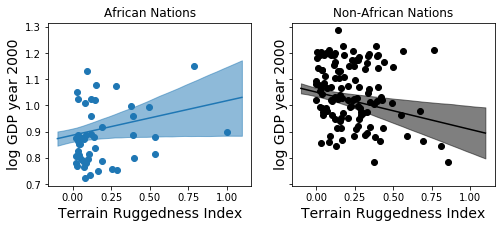

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(d_a['rugged_std'], d_a['log_gdp_std'], 'C0o')
ax1.plot(rugged_seq, mu_mean_a, 'C0')
ax1.fill_between(rugged_seq, mu_PI_a[0], mu_PI_a[1], color='C0', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(d_na['rugged_std'], d_na['log_gdp_std'], 'ko')
ax2.plot(rugged_seq, mu_mean_na, 'k')
ax2.fill_between(rugged_seq, mu_PI_na[0], mu_PI_na[1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14);

### Without Seychelles

In [70]:
with pm.Model() as model_8H3:
    a = pm.Normal('a', mu=1, sd=0.1, shape=dd['cont_africa'].nunique())
    b = pm.Normal('b', mu=0, sd=0.3, shape=dd['cont_africa'].nunique())
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic(
        'mu', a[dd['cont_africa'].values] + b[dd['cont_africa'].values] *
        (dd.rugged_std - 0.215))
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dd.log_gdp_std)
    trace_8H3 = pm.sample(1000, tune=1000)
    
    mean_q = pm.find_MAP()
    means = np.concatenate([mean_q[k].reshape(-1) for k in ['a', 'b', 'sigma']])
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, b, sigma]))  
    stds = np.sqrt(np.diagonal(cov_q))
    print('means: ', means.round(3))
    print('stds:  ', stds.round(3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1218.02draws/s]
logp = 137.53, ||grad|| = 4.3166: 100%|██████████| 26/26 [00:00<00:00, 1707.62it/s]  


means:  [ 1.051  0.88  -0.143  0.068  0.109]
stds:   [0.01  0.016 0.054 0.081 0.006]


In [71]:
varnames = ['a', 'b', 'sigma']
pm.summary(trace_8H3, varnames, kind='stats').round(3)

,mean,sd,hpd_3%,hpd_97%
a[0],1.051,0.010,1.034,1.069
a[1],0.880,0.017,0.849,0.912
b[0],-0.142,0.055,-0.243,-0.040
b[1],0.070,0.083,-0.094,0.216
sigma,0.111,0.006,0.101,0.123


In [97]:
rugged_seq = np.linspace(-0.1, 1.1, 30)

mu_a = np.apply_along_axis(
    lambda x: trace_8H3['a'][:, 1] + trace_8H3['b'][:, 1] * x, 
    axis=1, arr=rugged_seq[:, np.newaxis])
mu_mean_a = mu_a.mean(axis=1)
mu_PI_a = np.quantile(mu_a, [0.055, 0.945], axis=1)

mu_na = np.apply_along_axis(
    lambda x: trace_8H3['a'][:, 0] + trace_8H3['b'][:, 0] * x, 
    axis=1, arr=rugged_seq[:, np.newaxis])
mu_mean_na = mu_na.mean(axis=1)
mu_PI_na = np.quantile(mu_na, [0.055, 0.945], axis=1)

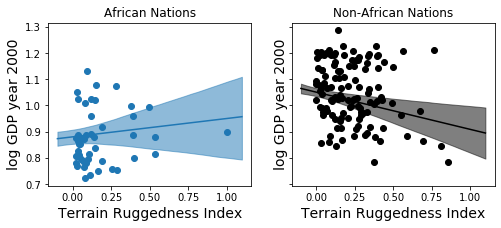

In [98]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(dd_a['rugged_std'], dd_a['log_gdp_std'], 'C0o')
ax1.plot(rugged_seq, mu_mean_a, 'C0')
ax1.fill_between(rugged_seq, mu_PI_a[0], mu_PI_a[1], color='C0', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(dd_na['rugged_std'], dd_na['log_gdp_std'], 'ko')
ax2.plot(rugged_seq, mu_mean_na, 'k')
ax2.fill_between(rugged_seq, mu_PI_na[0], mu_PI_na[1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14);

#### Compare WAIC 

In [103]:
with pm.Model() as model_1:
    a = pm.Normal('a', mu=1, sd=0.1)
    b = pm.Normal('b', mu=0, sd=0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b * (dd.rugged_std - 0.215))
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dd.log_gdp_std)
    trace_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1309.32draws/s]


In [105]:
with pm.Model() as model_2:
    a = pm.Normal('a', mu=1, sd=0.1, shape=dd['cont_africa'].nunique())
    b = pm.Normal('b', mu=0, sd=0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic(
        'mu', a[dd['cont_africa'].values] + b * (dd.rugged_std - 0.215))
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=dd.log_gdp_std)
    trace_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1746.67draws/s]


In [106]:
comp_df = pm.compare({'model1': trace_1, 'model2': trace_2, 'model3': trace_8H3})
comp_df

/Users/kani/Documents/KatrinaLand/explain-the-mark-experimentation/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model3,0,-261.262,4.238,0,0.756017,12.9644,0,True,deviance
model2,1,-257.868,3.84395,3.39383,0.243983,13.6338,3.56239,False,deviance
model1,2,-188.036,2.53228,73.226,4.33919e-09,14.3406,14.9205,False,deviance


#### Weighted prediction

In [111]:
rugged_seq = np.linspace(-0.1, 1.1, 30)

mu_a = np.apply_along_axis(
    lambda x: comp_df.weight[0] *
    (trace_8H3['a'][:, 1] + trace_8H3['b'][:, 1] * x) + comp_df.weight[1] *
    (trace_2['a'][:, 1] + trace_2['b'] * x) + comp_df.weight[2] *
    (trace_1['a'] + trace_1['b'] * x),
    axis=1,
    arr=rugged_seq[:, np.newaxis])
mu_mean_a = mu_a.mean(axis=1)
mu_PI_a = np.quantile(mu_a, [0.055, 0.945], axis=1)

mu_na = np.apply_along_axis(
    lambda x: comp_df.weight[0] *
    (trace_8H3['a'][:, 0] + trace_8H3['b'][:, 0] * x) + comp_df.weight[1] *
    (trace_2['a'][:, 0] + trace_2['b'] * x) + comp_df.weight[2] *
    (trace_1['a'] + trace_1['b'] * x),
    axis=1,
    arr=rugged_seq[:, np.newaxis])
mu_mean_na = mu_na.mean(axis=1)
mu_PI_na = np.quantile(mu_na, [0.055, 0.945], axis=1)

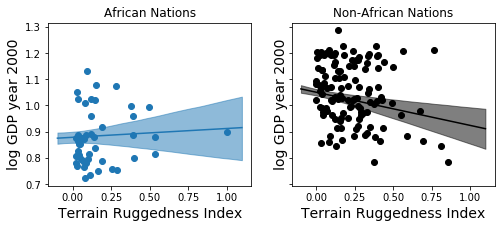

In [112]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(dd_a['rugged_std'], dd_a['log_gdp_std'], 'C0o')
ax1.plot(rugged_seq, mu_mean_a, 'C0')
ax1.fill_between(rugged_seq, mu_PI_a[0], mu_PI_a[1], color='C0', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(dd_na['rugged_std'], dd_na['log_gdp_std'], 'ko')
ax2.plot(rugged_seq, mu_mean_na, 'k')
ax2.fill_between(rugged_seq, mu_PI_na[0], mu_PI_na[1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14);

## 8H4

In [160]:
d = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/nettle.csv', sep=';')

In [161]:
d['lang.per.cap.log'] = np.log(d['num.lang'] / d['k.pop'])
d['lang.per.cap.log.cent'] = d['lang.per.cap.log'] / d['lang.per.cap.log'].mean()

d['area.log'] = np.log(d['area'])
d['area.log.cent'] = (d['area.log'] - d['area.log'].min()) / (
    d['area.log'].max() - d['area.log'].min())
d['area.log.cent'] = d['area.log.cent'] - d['area.log.cent'].mean()

d['mean.growing.season.cent'] = (
    d['mean.growing.season'] - d['mean.growing.season'].min()) / (
        d['mean.growing.season'].max() - d['mean.growing.season'].min())
d['mean.growing.season.cent'] = d['mean.growing.season.cent'] - d['mean.growing.season.cent'].mean()

d['sd.growing.season.cent'] = (
    d['sd.growing.season'] - d['sd.growing.season'].min()) / (
        d['sd.growing.season'].max() - d['sd.growing.season'].min())
d['sd.growing.season.cent'] = d['sd.growing.season.cent'] - d['sd.growing.season.cent'].mean()

In [163]:
with pm.Model() as model_1:
    a = pm.Normal('a', mu=1, sd=0.1)
    bA = pm.Normal('bA', mu=0, sd=0.3)
    bM = pm.Normal('bM', mu=0, sd=0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic(
        'mu', a + bA * d['area.log.cent'] + bM * d['mean.growing.season.cent'])
    y = pm.Normal('y', mu, sigma, observed=d['lang.per.cap.log.cent'])
    trace_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1285.49draws/s]


In [164]:
pm.summary(trace_1, ['a', 'bA', 'bM'], kind='stats').round(3)

,mean,sd,hpd_3%,hpd_97%
a,1.000,0.029,0.942,1.054
bA,0.207,0.146,-0.087,0.469
bM,-0.283,0.117,-0.488,-0.044


In [166]:
with pm.Model() as model_2:
    a = pm.Normal('a', mu=1, sd=0.1)
    bA = pm.Normal('bA', mu=0, sd=0.3)
    bS = pm.Normal('bS', mu=0, sd=0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic(
        'mu', a + bA * d['area.log.cent'] + bS * d['sd.growing.season.cent'])
    y = pm.Normal('y', mu, sigma, observed=d['lang.per.cap.log.cent'])
    trace_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bS, bA, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1193.33draws/s]


In [167]:
pm.summary(trace_2, ['a', 'bA', 'bS'], kind='stats').round(3)

,mean,sd,hpd_3%,hpd_97%
a,1.000,0.031,0.940,1.056
bA,0.236,0.155,-0.079,0.512
bS,0.194,0.170,-0.155,0.502


In [173]:
with pm.Model() as model_3:
    a = pm.Normal('a', mu=1, sd=0.1)
    bA = pm.Normal('bA', mu=0, sd=0.3)
    bM = pm.Normal('bM', mu=0, sd=0.3)
    bS = pm.Normal('bS', mu=0, sd=0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic(
        'mu', a + bA * d['area.log.cent'] +
        bM * d['mean.growing.season.cent'] + bS * d['sd.growing.season.cent'])
    y = pm.Normal('y', mu, sigma, observed=d['lang.per.cap.log.cent'])
    trace_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bS, bM, bA, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1177.48draws/s]


In [175]:
pm.summary(trace_3, ['a', 'bA', 'bM', 'bS'], kind='stats').round(3)

,mean,sd,hpd_3%,hpd_97%
a,1.000,0.029,0.945,1.056
bA,0.087,0.163,-0.211,0.403
bM,-0.319,0.117,-0.534,-0.090
bS,0.267,0.163,-0.013,0.601


In [179]:
with pm.Model() as model_4:
    a = pm.Normal('a', mu=1, sd=0.1)
    bA = pm.Normal('bA', mu=0, sd=0.3)
    bM = pm.Normal('bM', mu=0, sd=0.3)
    bS = pm.Normal('bS', mu=0, sd=0.3)
    bMS = pm.Normal('bMS', mu=0, sd=0.3)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic(
        'mu', a + bA * d['area.log.cent'] +
        bM * d['mean.growing.season.cent'] + bS * d['sd.growing.season.cent'] +
        bMS * d['mean.growing.season.cent'] * d['sd.growing.season.cent'])
    y = pm.Normal('y', mu, sigma, observed=d['lang.per.cap.log.cent'])
    trace_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bMS, bS, bM, bA, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 990.07draws/s] 


In [171]:
pm.summary(trace_4, ['a', 'bA', 'bM', 'bS', 'bMS'], kind='stats').round(3)

,mean,sd,hpd_3%,hpd_97%
a,1.001,0.029,0.948,1.056
bA,0.075,0.158,-0.226,0.363
bM,-0.293,0.117,-0.522,-0.077
bS,0.270,0.162,-0.037,0.563
bMS,0.280,0.276,-0.225,0.795


### Compare WAIC

In [187]:
comp_df = pm.compare({'mean': trace_1, 'sd': trace_2, 'mean + st': trace_3, 'mean * st': trace_4})
comp_df

/Users/kani/Documents/KatrinaLand/explain-the-mark-experimentation/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
mean * st,0,12.2953,4.88766,0,0.541252,15.7126,0,True,deviance
mean + st,1,13.5814,4.61546,1.2861,0.284368,14.6646,0.845983,True,deviance
mean,2,15.547,3.97499,3.2517,0.147597,14.8167,2.42518,True,deviance
sd,3,21.1491,4.30781,8.85381,0.0267829,14.5307,3.98314,True,deviance


### Plot posterior with interaction

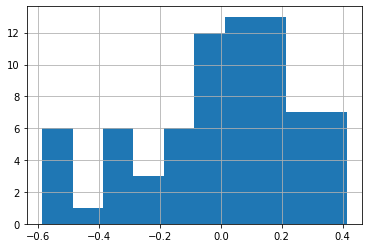

In [172]:
d['mean.growing.season.cent'].hist()

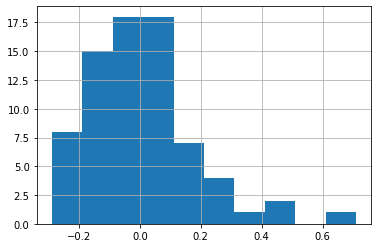

In [177]:
d['sd.growing.season.cent'].hist()

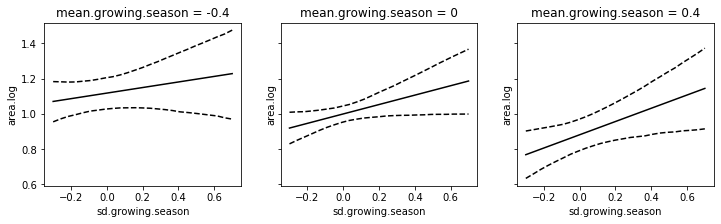

In [186]:
seq_s = np.linspace(-0.3, 0.7, 25)
f, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 3))

for ax, m in zip(axs.flat, [-0.4, 0, 0.4]):
    mu = np.apply_along_axis(lambda x: trace_4['a'] + trace_4['bM'] * m +
                             trace_4['bS'] * x + trace_4['bMS'] * m * x,
                             axis=1,
                             arr=seq_s[:, np.newaxis])
    mu_mean = mu.mean(1)
    mu_PI = np.quantile(mu, [0.055, 0.945], axis=1)
    ax.plot(seq_s, mu_mean, 'k')
    ax.plot(seq_s, mu_PI[0], 'k--')
    ax.plot(seq_s, mu_PI[1], 'k--')
    ax.set_ylabel('area.log')
    ax.set_xlabel('sd.growing.season')
    ax.set_title(f'mean.growing.season = {m}')

The idea is that, in nations with longer average growing seasons, high variance makes storage and redistribution even more important than it would be otherwise.